In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import PIL as pil
import re

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = Path('../data')

In [ ]:
[x for x in path.iterdir()]

In [ ]:
data_labels = pd.read_csv(path/'train.csv')

In [ ]:
data_labels.head()

In [5]:
fnames = get_image_files(path/'train_images')

In [6]:
fnames[:3]

[PosixPath('../data/train_images/a7f29f0b3.jpg'),
 PosixPath('../data/train_images/6e6b79dc4.jpg'),
 PosixPath('../data/train_images/44415ab00.jpg')]

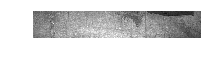

In [7]:
img_test = open_image(fnames[1])
img_test.show()

In [ ]:
img_test.size

In [ ]:
data_lbls = data_labels.iloc[0,1]

In [ ]:
data_lbls

In [ ]:
class_id = int(data_labels.iloc[0,0].split('_')[1])

In [ ]:
class_id

In [ ]:
lbl_img = np.zeros(img_test.size, dtype='int16').reshape(-1)

In [ ]:
lbl_img

In [ ]:
regex = '[0-9]+\s[0-9]+'

In [ ]:
data_lbl_pairs = [list(map(int, x.split())) for x in re.findall(regex, data_lbls)]

In [ ]:
data_lbl_pairs = list(map(lambda pair: [pair[0], pair[0]+pair[1]], data_lbl_pairs))

In [ ]:
lbl_img[data_lbl_pairs[0][0]:data_lbl_pairs[0][1]]

In [ ]:
for pair in data_lbl_pairs:
    lbl_img[pair[0]:pair[1]] = class_id

In [ ]:
lbl_img.resize(img_test.size)

In [ ]:
def set_label(arr, pair, class_id):
    arr[pair[0]:pair[1]] = class_id

In [ ]:
data_labels.head()

In [ ]:
test_dict = {}
for _, row in data_labels.iterrows():
    image_name, class_id = row['ImageId_ClassId'].split('_')
    enc_pix = row['EncodedPixels']
    
    if image_name not in test_dict.keys():
        test_dict[image_name] = np.zeros(img_test.size, dtype='int16').reshape(-1)
    else:
        test_dict[image_name] = test_dict[image_name].reshape(-1)
        
    if enc_pix is not np.nan:

        data_lbl_pairs = [list(map(int, x.split())) for x in re.findall(regex, enc_pix)]
        data_lbl_pairs = list(map(lambda pair: [pair[0], pair[0]+pair[1]], data_lbl_pairs))

        for pair in data_lbl_pairs:
            test_dict[image_name][pair[0]:pair[1]] = class_id

    test_dict[image_name].resize(img_test.size)

In [ ]:
for key in test_dict:
    imname = key.split('.')[0] + '.png'
    im = pil.Image.fromarray(test_dict[key])
    im.save(f'../data/labels/{imname}')

In [94]:
get_y_fn = lambda x: path/f'labels/{x.stem}.png'

In [119]:
src = (SegmentationItemList.from_folder(path/'train_images')
       .random_split_by_pct(0.2)
       .label_from_func(get_y_fn, classes=[0,1,2,3,4]))

In [120]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 5344MB of GPU RAM free


In [121]:
src_size = np.array(img_test.shape[1:])
size = src_size // 2

In [122]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [123]:
void_code = 0
def dice_multiclass(inp, target):
    
    #The shape of the mask [4, 1, 128, 800] at index 1 does not match the shape of the indexed tensor [4, 5, 128, 800] at index 1
    # target shape = (4, 1, 128, 800), (batch_size, filters[n_classes], pixels_w, pixels_l)
    # input_shape = (4, 5, 128, 800)
    
    target = target.squeeze(1)
    mask = target != 0
    if mask.sum() < 1:
        return torch.tensor(1.0)
    inp = inp.argmax(dim=1)[mask]
    target = target[mask]
    
    n = target.shape[0]
    inp = inp.view(n,-1)
    target = target.view(n,-1)

    intersect = (inp == target).sum().float()
    union = inp.new_ones(inp.shape).sum()*2
    return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())

In [124]:
metrics=dice_multiclass
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [125]:
lr=3.63E-05

In [126]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_multiclass
1,0.160878,0.154652,0.044629
2,0.156337,0.146110,0.044761
3,0.178831,0.141631,0.044574


KeyboardInterrupt: 

In [ ]:
void_code = 0
def dice_multiclass(inp, target):
    
    #The shape of the mask [4, 1, 128, 800] at index 1 does not match the shape of the indexed tensor [4, 5, 128, 800] at index 1
    # target shape = (4, 1, 128, 800), (batch_size, filters[n_classes], pixels_w, pixels_l)
    # input_shape = (4, 5, 128, 800)
    target = target.squeeze(1)
    mask = target != 0
    inp = inp.argmax(dim=1)[mask]
    if inp.shape == torch.Size([0]):
        return 1.0
    target = target[mask]

    n = target.shape[0]
    preds = inp.view(n,-1)
    truth = target.view(n,-1)

    intersect = (preds == truth).sum().float()
    union = float(preds.shape[0]*preds.shape[1] + truth.shape[0]*truth.shape[1])
    return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())

In [65]:
i = torch.tensor(np.zeros(shape=(4,5,128,800)))
i[:,0,:,:] = 1
t = torch.tensor(np.random.randint(5, size=(4,1,128,800)))

n = t.shape[0]
i = i.argmax(dim=1).view(n,-1)
t = t.view(n,-1)


In [72]:
inter = (i==t).sum().float()

In [89]:
un = i.new_ones(i.shape).sum()*2

In [90]:
(2. * inter / un if un > 0 else un.new([1.]).squeeze())

tensor(0.1997)

In [113]:
m.sum() 

tensor(0, dtype=torch.uint8)